In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.datasets import fetch_openml
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import neighbors
from sklearn.metrics import roc_curve, precision_recall_curve, auc, make_scorer, recall_score, accuracy_score, precision_score, confusion_matrix
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import LabelEncoder

%matplotlib inline 
sns.set(color_codes=True)
np.random.seed(0)

df = pd.read_csv('final_project.csv')

__DD:__ We have nulls ranging from 21 - 47 but given the volume and distributions we can probably revisit if difficulty in model(s).

In [2]:
#df.isnull().sum()

In [3]:
df.x32.describe()

count     159969
unique        12
top        0.01%
freq       40767
Name: x32, dtype: object

__DD:__ found that x32 has "%" that needs to be converted to float therefore:

In [4]:
df['x32'] = df['x32'].str.replace('%', '')
df['x32'] = df['x32'].astype(float)
df.x32.describe()

count    159969.000000
mean         -0.000011
std           0.010400
min          -0.050000
25%          -0.010000
50%           0.000000
75%           0.010000
max           0.050000
Name: x32, dtype: float64

__DD:__ found that x37 has "$" that needs to be converted to float therefore:

In [5]:
df['x37'] = df['x37'].str.replace('$', '')
df['x37'] = df['x37'].astype(float)
df.x37.describe()

count    159977.000000
mean          0.377628
std         999.945334
min       -4734.540000
25%        -691.370000
50%         -13.760000
75%         664.210000
max        5546.990000
Name: x37, dtype: float64

__DD:__ Find all variables that have correlation greater than .75

In [6]:
corr_matrix = df.corr().abs()
# Select upper triangle of correlation matrix
correlated = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
# Find index of feature columns with correlation greater than 0.5
dropme_correlated = [column for column in correlated.columns if any(correlated[column] > 0.75)]
dropme_correlated

['x6', 'x41']

__DD:__ Findout which variables x6 and x41 are correlated with:

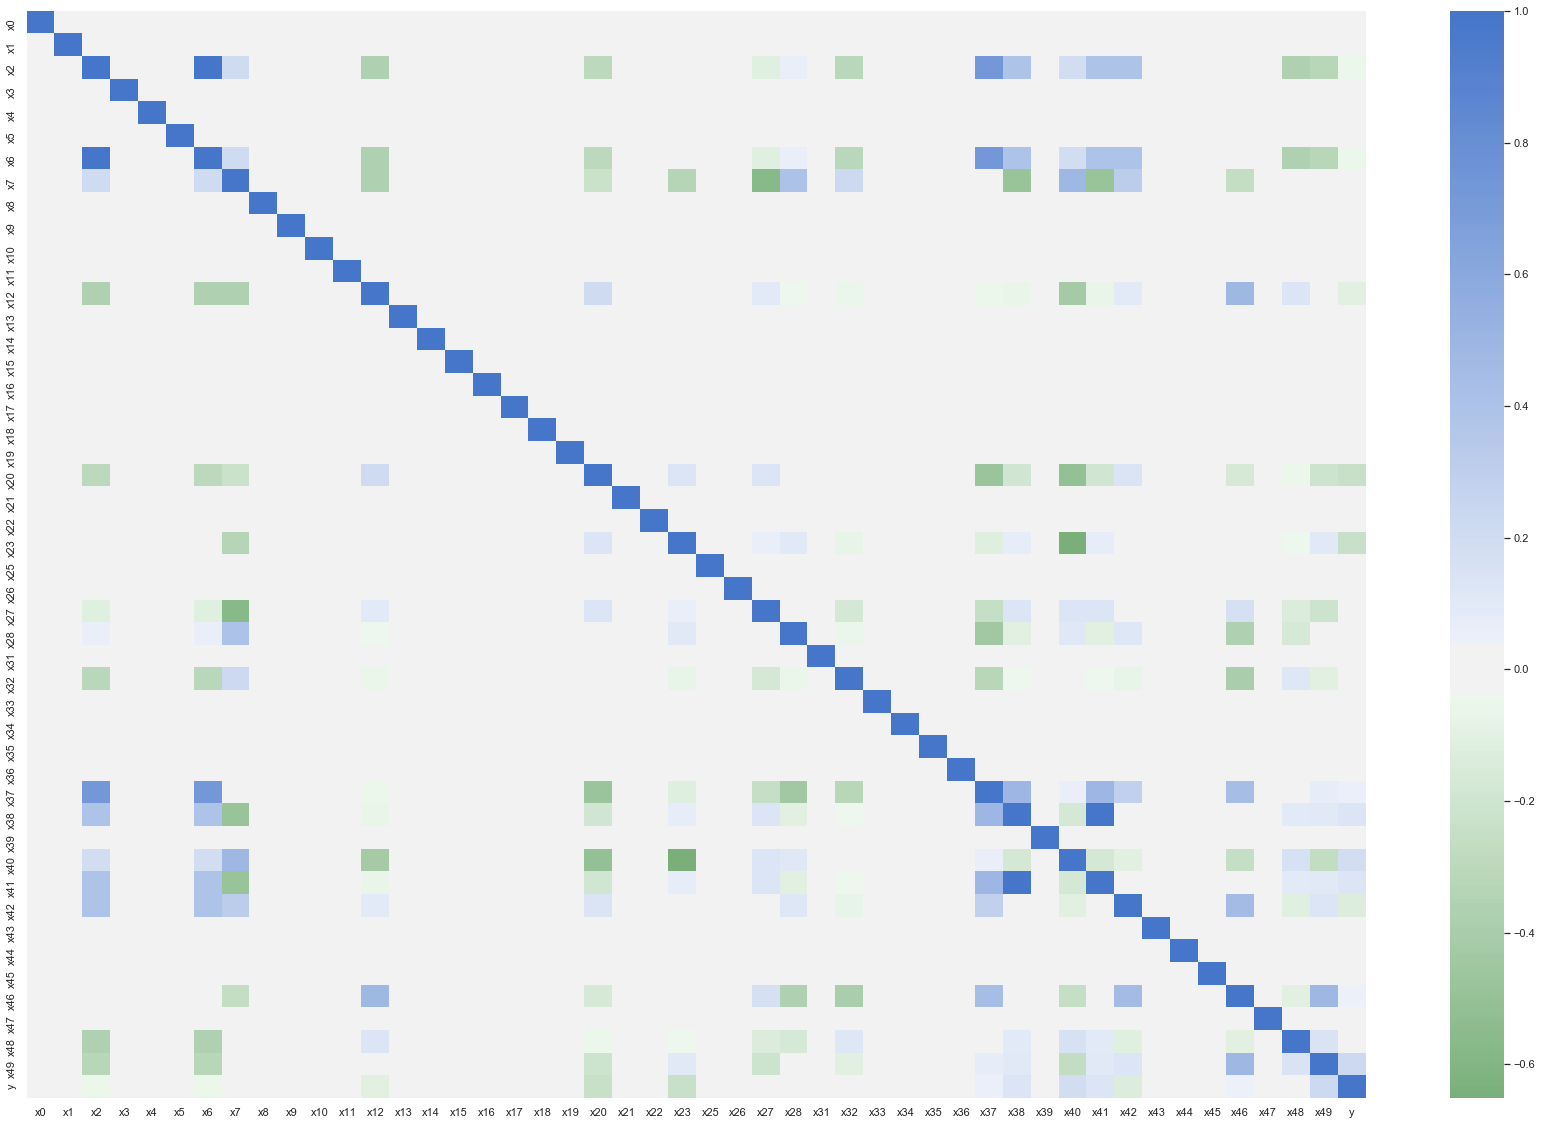

In [7]:
danpallet= sns.diverging_palette(128, 255, l=50, n=7, center="light",as_cmap=True)
plt.figure(figsize=(30,20))
c= df.corr()
sns.heatmap(c,annot=False, center=0, cmap=danpallet)

__DD:__ The following are highly (apparently perfectly) correlated

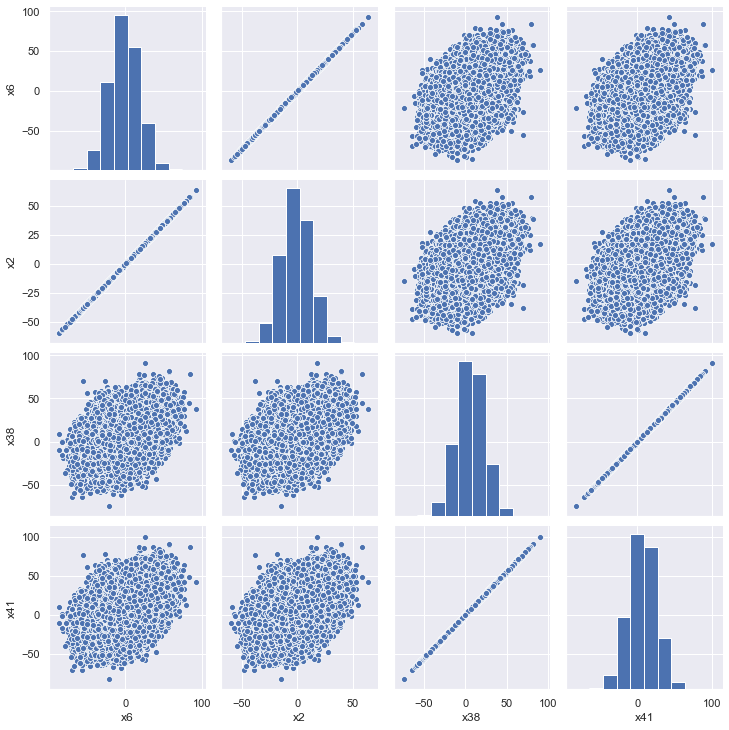

In [8]:
d=['x6', 'x2','x38','x41']
sns.pairplot(df[d])

__DD:__ Drop x6 and x41

In [9]:
df=df.drop(df[dropme_correlated], axis=1)

__DD:__ All distributions are reasonably normal and centered near 0 __with exception to x37__. Found that when converting to float we lost the negative symbols so resolved by using replace rather than regexp.

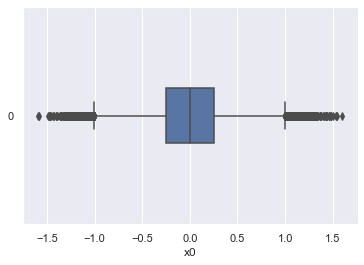

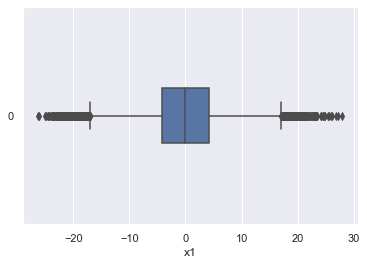

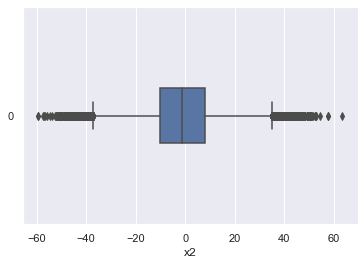

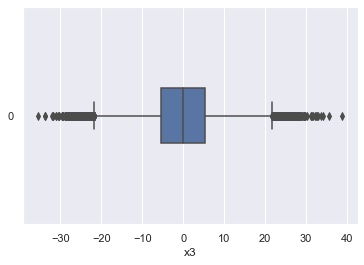

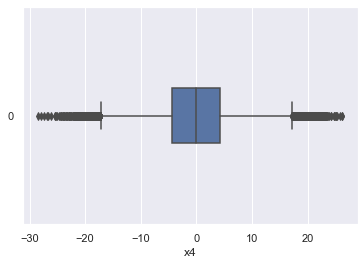

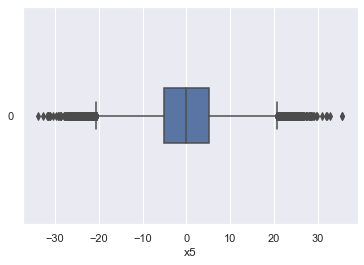

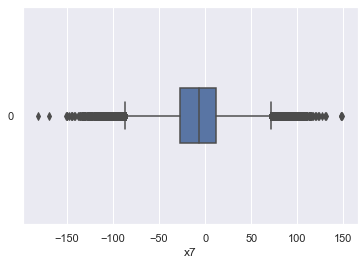

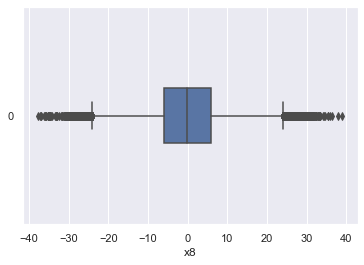

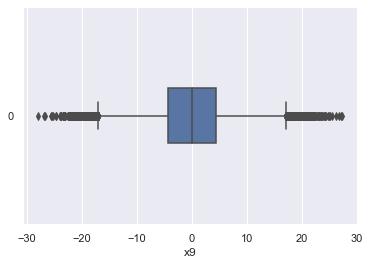

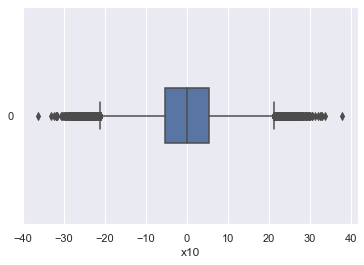

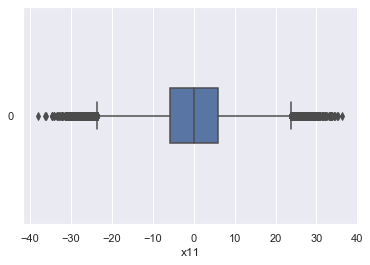

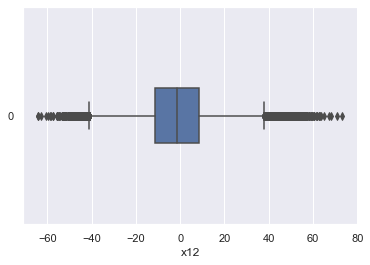

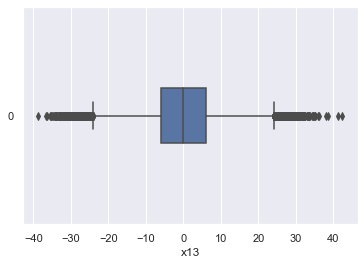

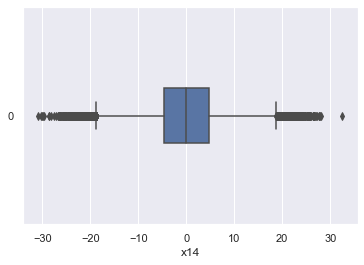

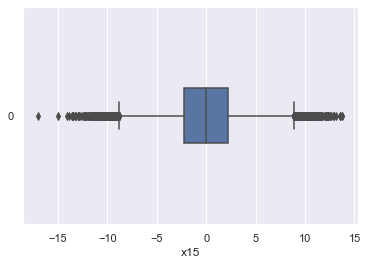

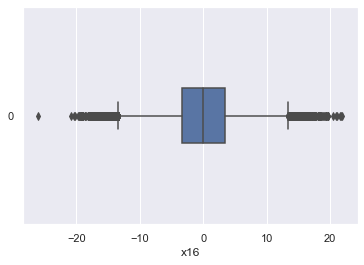

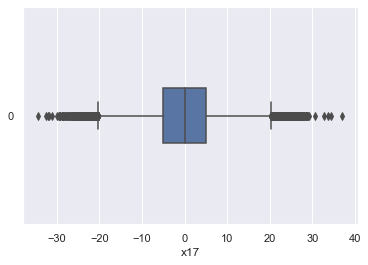

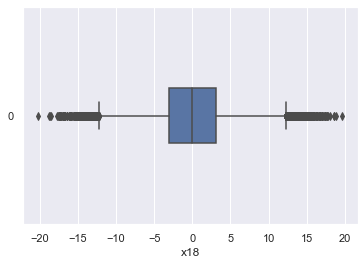

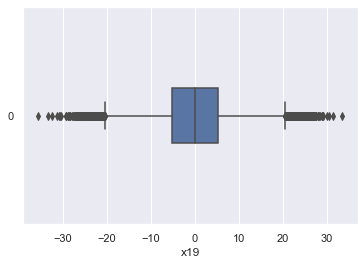

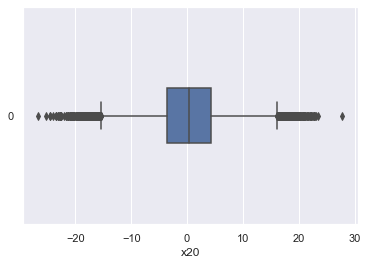

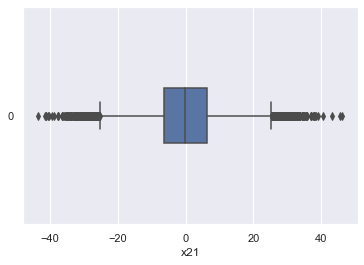

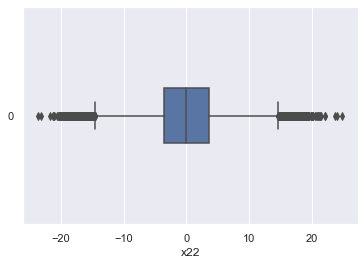

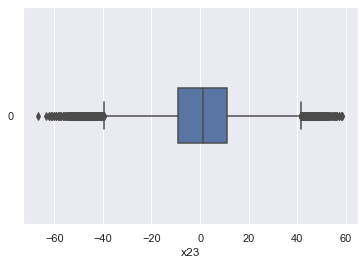

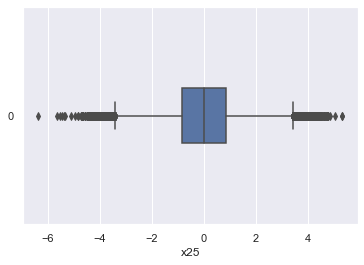

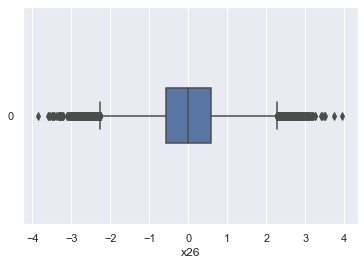

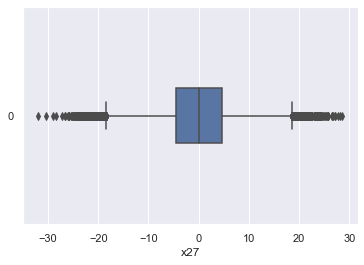

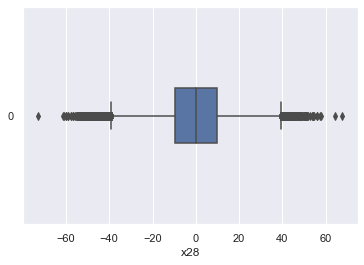

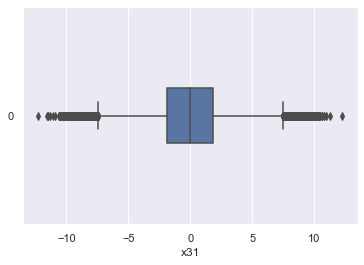

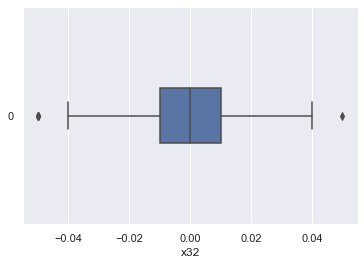

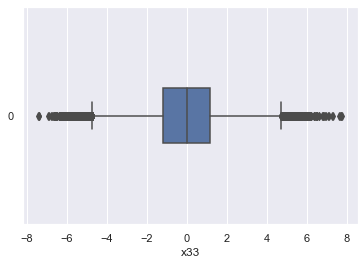

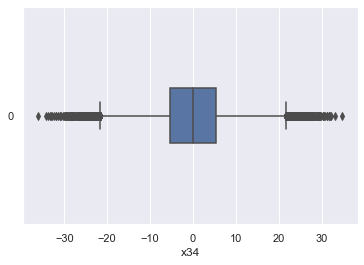

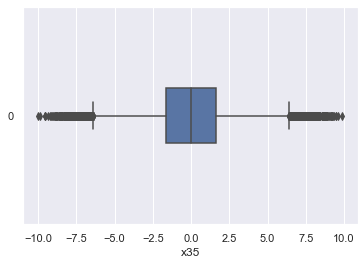

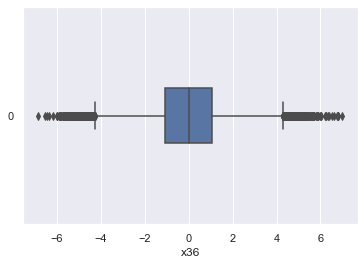

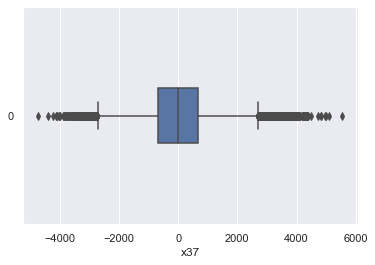

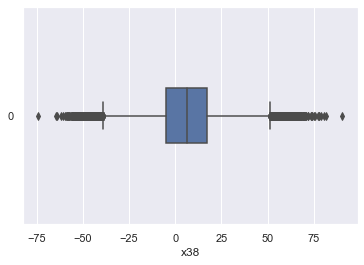

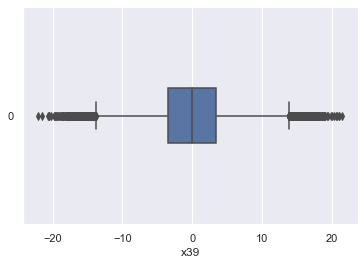

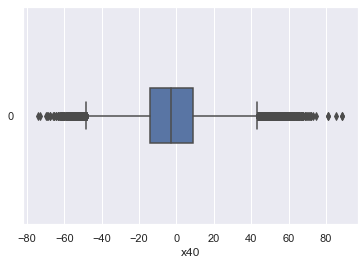

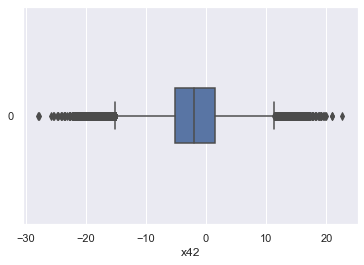

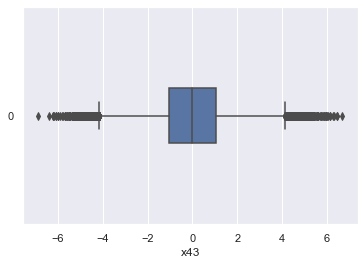

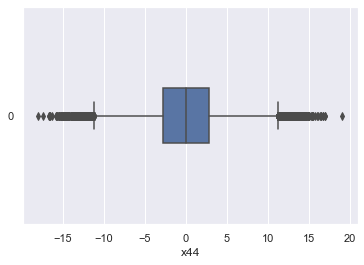

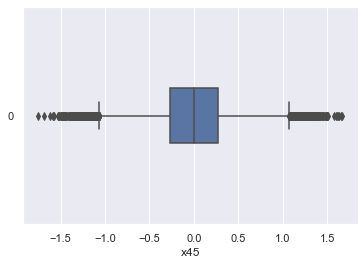

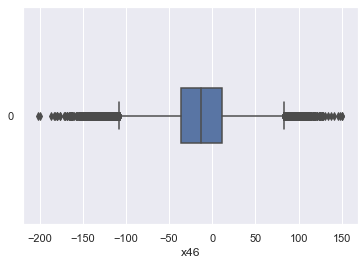

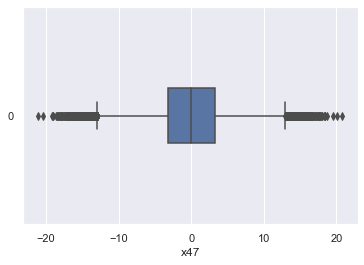

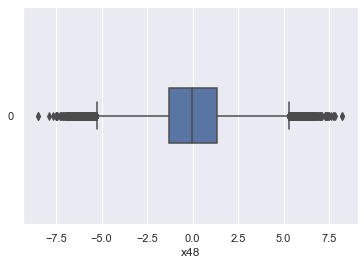

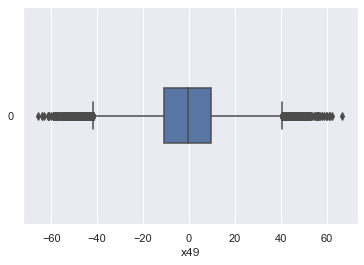

In [10]:
df_continuousVariables = df.drop(['y','x24','x29','x30'], axis=1)
cols=df_continuousVariables.columns
for col in cols:
    sns.boxplot(data=df_continuousVariables[col],orient="h", width=.25).set(xlabel=col)
    plt.show()

In [11]:
################################################
#Temporarily tiny sample to get code running
# df=df.sample(n=500)
################################################

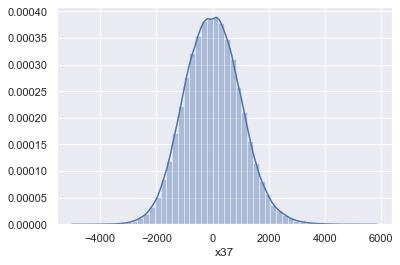

In [12]:
sns.set(color_codes=True)
sns.distplot(df_continuousVariables['x37'])

The response variable is slightly unblalanced but testing a simpl sample of 1/5 presents a svery similar distribution

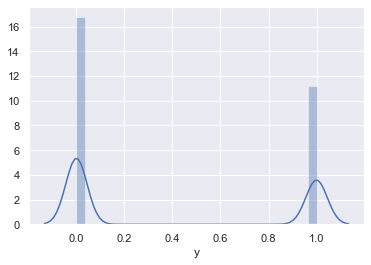

In [13]:
sns.distplot(df['y'])

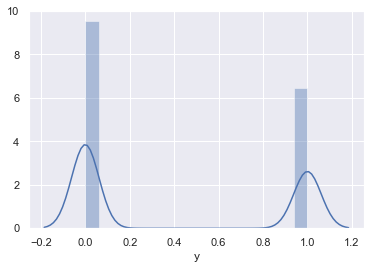

In [14]:
from random import sample
df_responseVariableSample=df['y'].sample(n=int(len(df)/5))
sns.distplot(df_responseVariableSample)

__DD__: Initial model; try SGD. Sensitive to data scale, needs to be centered on 0

_"By increasing the sample size, you reduce the variability of the statistic in question, which will reduce its chances of failing to be in the rejection region when its true sampling distribution would indicate that it should be in the rejection region."_

In [15]:
cols=df_continuousVariables.columns.tolist()

In [16]:
X = df.drop(['y'], axis=1)
y = df.y

https://scikit-learn.org/stable/auto_examples/compose/plot_column_transformer_mixed_types.html#sphx-glr-auto-examples-compose-plot-column-transformer-mixed-types-py

In [17]:
numeric_features = cols
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', StandardScaler())])

categorical_features = ['x24','x29','x30']
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])

https://scikit-learn.org/stable/modules/sgd.html#classification

In [18]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

clf = Pipeline(steps=[('preprocessor', preprocessor),
                      ('classifier', SGDClassifier(loss="log", penalty="l2", max_iter=25))])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True)

clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

model score: 0.696


In [19]:
print(y_train.value_counts(normalize=True))

0    0.598414
1    0.401586
Name: y, dtype: float64


In [20]:
print(y_test.value_counts(normalize=True))

0    0.600187
1    0.399813
Name: y, dtype: float64


Finding a reasonable regularization term  is best done using GridSearchCV, usually in the range 10.0**-np.arange(1,7).

https://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html#sphx-glr-auto-examples-neighbors-plot-classification-py

https://towardsdatascience.com/fine-tuning-a-classifier-in-scikit-learn-66e048c21e65

In [21]:
plt.style.use("ggplot")

In [22]:
clf = RandomForestClassifier(n_jobs=-1)

param_grid = {
    'min_samples_split': [3, 5, 10], 
    'n_estimators' : [100, 300],
    'max_depth': [3, 5, 15, 25],
    'max_features': [3, 5, 10, 20]
}

scorers = {
    'precision_score': make_scorer(precision_score),
    'recall_score': make_scorer(recall_score),
    'accuracy_score': make_scorer(accuracy_score)
}

In [23]:
def grid_search_wrapper(refit_score='precision_score'):
    """
    fits a GridSearchCV classifier using refit_score for optimization
    prints classifier performance metrics
    """
    skf = StratifiedKFold(n_splits=10)
    grid_search = GridSearchCV(clf, param_grid, scoring=scorers, refit=refit_score,
                           cv=skf, return_train_score=True, n_jobs=-1)
    
    
    
    
    
    grid_search.fit(X_train.values, y_train.values)

    # make the predictions
    y_pred = grid_search.predict(X_test.values)

    print('Best params for {}'.format(refit_score))
    print(grid_search.best_params_)

    # confusion matrix on the test data.
    print('\nConfusion matrix of Random Forest optimized for {} on the test data:'.format(refit_score))
    print(pd.DataFrame(confusion_matrix(y_test, y_pred),
                 columns=['pred_neg', 'pred_pos'], index=['neg', 'pos']))
    return grid_search

__DD:__ here we fit the imputer only on train data so no leakage into test data:

In [24]:
X = df.drop(['y'], axis=1)
y = df.y

In [25]:
categorical_feature_mask = X.dtypes == object
categorical_columns = X.columns[categorical_feature_mask].tolist()
numerical_columns = cols

In [26]:
numericImputer = SimpleImputer(missing_values=np.nan, strategy='mean')
numericImputer.fit(X[cols])
X[cols]=numericImputer.transform(X[cols])

In [27]:
categoricImputer = SimpleImputer(strategy='constant', fill_value='missing')
categoricImputer.fit(X[categorical_columns])
X[categorical_columns] = categoricImputer.transform(X[categorical_columns])

In [28]:
oneHotEncoder = LabelEncoder()
X[categorical_columns] = X[categorical_columns].apply(lambda col: oneHotEncoder.fit_transform(col))

In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y)

In [30]:
#grid_search_clf = grid_search_wrapper(refit_score='precision_score')

In [ ]:
grid_search_clf = grid_search_wrapper(refit_score='recall_score')

C:\Users\danie\anaconda3\envs\tensorflow_gpuenv\lib\site-packages\joblib\externals\loky\process_executor.py:706: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  "timeout or by a memory leak.", UserWarning


In [ ]:
results = pd.DataFrame(grid_search_clf.cv_results_)
results = results.sort_values(by='mean_test_recall_score', ascending=False)
results[['mean_test_precision_score', 'mean_test_recall_score', 'mean_test_accuracy_score', 'param_max_depth', 'param_max_features', 'param_min_samples_split', 'param_n_estimators']].round(3).head()

In [ ]:
y_scores = grid_search_clf.predict_proba(X_test)[:, 1]

In [ ]:
p, r, thresholds = precision_recall_curve(y_test, y_scores)

In [ ]:
def adjusted_classes(y_scores, t):
    """
    This function adjusts class predictions based on the prediction threshold (t).
    Will only work for binary classification problems.
    """
    return [1 if y >= t else 0 for y in y_scores]

def precision_recall_threshold(p, r, thresholds, t=0.5):
    """
    plots the precision recall curve and shows the current value for each
    by identifying the classifier's threshold (t).
    """
    
    # generate new class predictions based on the adjusted_classes
    # function above and view the resulting confusion matrix.
    y_pred_adj = adjusted_classes(y_scores, t)
    print(pd.DataFrame(confusion_matrix(y_test, y_pred_adj),
                       columns=['pred_neg', 'pred_pos'], 
                       index=['neg', 'pos']))
    
    # plot the curve
    plt.figure(figsize=(8,8))
    plt.title("Precision and Recall curve ^ = current threshold")
    plt.step(r, p, color='b', alpha=0.2,
             where='post')
    plt.fill_between(r, p, step='post', alpha=0.2,
                     color='b')
    plt.ylim([0.5, 1.01]);
    plt.xlim([0.5, 1.01]);
    plt.xlabel('Recall');
    plt.ylabel('Precision');
    
    # plot the current threshold on the line
    close_default_clf = np.argmin(np.abs(thresholds - t))
    plt.plot(r[close_default_clf], p[close_default_clf], '^', c='k',
            markersize=15)

In [ ]:
precision_recall_threshold(p, r, thresholds, 0.5)

In [ ]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    """
    Modified from:
    Hands-On Machine learning with Scikit-Learn
    and TensorFlow; p.89
    """
    plt.figure(figsize=(8, 8))
    plt.title("Precision and Recall Scores as a function of the decision threshold")
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.ylabel("Score")
    plt.xlabel("Decision Threshold")
    plt.legend(loc='best')

In [ ]:
plot_precision_recall_vs_threshold(p, r, thresholds)

In [ ]:
# #List Hyperparameters that we want to tune.
# leaf_size = list(range(1,50))
# n_neighbors = list(range(1,30))
# p=[1,2]
# #Convert to dictionary
# hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)
# #Create new KNN object
# knn_2 = KNeighborsClassifier()
# #Use GridSearch
# clf = GridSearchCV(knn_2, hyperparameters, cv=10)
# #Fit the model
# best_model = clf.fit(X_train, y_train)
# #Print The value of best Hyperparameters
# print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
# print('Best p:', best_model.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

In [ ]:
# leaf_size = list(range(1,50))
# n_neighbors = list(range(1,30))
# p=[1,2]
# #Convert to dictionary
# hyperparameters = dict(leaf_size=leaf_size, n_neighbors=n_neighbors, p=p)

In [ ]:
# knn_2 = KNeighborsClassifier()
# #Use GridSearch
# clf = GridSearchCV(knn_2, hyperparameters, cv=10)
# #Fit the model
# best_model = clf.fit(x,y)
# #Print The value of best Hyperparameters
# print('Best leaf_size:', best_model.best_estimator_.get_params()['leaf_size'])
# print('Best p:', best_model.best_estimator_.get_params()['p'])
# print('Best n_neighbors:', best_model.best_estimator_.get_params()['n_neighbors'])

In [ ]:
# param_grid = hyperparameters

# scorers = {
#     'precision_score': make_scorer(precision_score),
#     'recall_score': make_scorer(recall_score),
#     'accuracy_score': make_scorer(accuracy_score)
# }

qtw final

Required
Deliverable:
I want you to minimize my dollar cost on an UNKNOWN dataset
That means one you can never see.  Ever.
Each False Positive costs me $10
Each False Negative costs me $500
True Positives and True Negatives cost me $0

Problem:
Cost-sensitive learning 

cost function:
 Total Cost = 10 * Count of FP + 500 * Count of FN

Goal: minimize False Negative or Type-II error


Precision = TruePositives / (TruePositives + FalsePositives)

Recall = TruePositives / (TruePositives + FalseNegatives)

The intuition for recall is that it is not concerned with false positives and it minimizes false negatives. 

Precision is a metric that calculates the percentage of correct predictions for the positive class. Recall calculates the percentage of correct predictions for the positive class out of all positive predictions that could be made. Maximizing precision will minimize the false-positive errors, whereas maximizing recall will minimize the false-negative errors.

Methods
Metric Choice


Fbeta 

Fbeta = ((1 + beta^2) * Precision * Recall) / (beta^2 * Precision + Recall)

When choosing beta in your F-beta score the more you care about recall over precision the higher beta you should choose. For example, with F1 score we care equally about recall and precision with F2 score, recall is twice as important to us.

F50

How to compute:
from sklearn.metrics import fbeta_score
y_pred_class = y_pred_pos > threshold
fbeta_score(y_true, y_pred_class, beta)

https://scikit-learn.org/stable/modules/generated/sklearn.metrics.fbeta_score.html

calculate the f2-measure
from sklearn.metrics import fbeta_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
# perfect precision, 50% recall
y_true = [0, 0, 0, 0, 0, 1, 1, 1, 1, 1]
y_pred = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
p = precision_score(y_true, y_pred)
r = recall_score(y_true, y_pred)
f = fbeta_score(y_true, y_pred, beta=2.0)
print('Result: p=%.3f, r=%.3f, f=%.3f' % (p, r, f))

eda

check y distribution

pca and see

xgb f beta
if have time rf

ref
https://machinelearningmastery.com/fbeta-measure-for-machine-learning/
https://stackoverflow.com/questions/41060719/using-evaluation-functions-with-parameter-in-xgboost-f-beta